# **Judea Pearl and the Ladder of Causation**

## The Ladder of Causation:

1. Rung 1: **Association** -> Observing -> "*How does observing X change my belief in Y?*";
2. Rung 2: **Intervention** -> Doing -> "*What will happen to Y if I do X?*";
3. Rung 3: **Counterfactual** -> Imagining -> "*If I had done X, what would Y be?*".

In [1]:
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

COLORS = [
    '#00B0F0',
    '#FF0000'
]

## Associations

- Associations are related to *observing* and allow us to generate predictions;
- One way to view association is using of **conditional probability**. This just give us *non-causal association*;
- **Structural causal models (or SCMs)** is useful for encoding causal relationship. We will use it as our *data-generating process* for this part;
- SCMs: endogenous (children of another variable), exogenous (root nodes in the graph, also call noise vars);
- `:=`: walrus operator, implies the relationship is *directional/asymmetric*;
- *Indicator function*: return 1 when condition is met and 0 otherwise.

**Booktore Example**

First we build a SCM

In [2]:
class BookSCM:
    """A Structural Causal Model for our model on the Book A and B
    """
    def __init__(self, random_seed=None):
        self.random_seed = random_seed
        self.u_0 = stats.uniform()
        self.u_1 = stats.norm()
        
    def sample(self, sample_size=100):
        """Samples from the SCM"""
        if self.random_seed:
            np.random.seed(self.random_seed)
        
        u_0 = self.u_0.rvs(sample_size)
        u_1 = self.u_1.rvs(sample_size)
        a = u_0 > .61
        b = (a + .5 * u_1) > .2
        
        return a, b    

Instantiating our SCM and set random seed to 45:

In [3]:
scm = BookSCM(random_seed=45)

Sampling 100 samples from it:

In [4]:
buy_book_a, buy_book_b = scm.sample(100)

buy_book_a.shape, buy_book_b.shape

((100,), (100,))

In [11]:
proba_book_a = buy_book_a.sum() / buy_book_a.shape[0]
proba_book_b = buy_book_b.sum() / buy_book_b.shape[0]

print(f'Probability of buying book A: {proba_book_a:0.3f}')
print(f'Probability of buying book B: {proba_book_b:0.3f}')

Probability of buying book A: 0.390
Probability of buying book B: 0.580


Computing the `P(book A | book B)`:

In [6]:
p_bookA_given_bookB = (buy_book_a[buy_book_b].sum() / 
                        buy_book_a[buy_book_b].shape[0])

print(f'Probabilty of buying book A given B: {p_bookA_given_bookB:0.3f}')

Probabilty of buying book A given B: 0.638


If no relationship is expected, the probability should be 50%, we've done this without knowing the generating process of data (only observation). We can use this to predict buying book A given book B, this is essence of *Supervised Machine Learning*. Bonus:

In [12]:
proba_book_b_given_book_a = np.where(buy_book_a, buy_book_b, 0).sum() / buy_book_a.sum()
print(f'Probability of buying book B given A: {proba_book_b_given_book_a:0.3f}')

Probability of buying book B given A: 0.949


## Interventions

- The idea is we change one thing in the world and observe whether and how this change affects another thing in the world:

    `P( Y = 1 | do( X = 0 ) )`;

- *Intervening* (actively set 1 or more vars to a fixed value or distribution) <> *conditioning* (modified our view of data);
- Remember when changing the world:
  - change in X will influence all its descendants;
  - X will become independent of its ancestors;
  - both situations will take place.

A new example, we change A, B to continuous variables:

In [21]:
SAMPLE_SIZE = 100

np.random.seed(45)

u_0 = np.random.randn(SAMPLE_SIZE)
u_1 = np.random.randn(SAMPLE_SIZE)
a = u_0
b = 5 * a + u_1

r, p = stats.pearsonr(a, b)

print(f'Mean of B before any intervention: {b.mean():.3f}')
print(f'Variance of B before any intervention: {b.var():.3f}')
print(f'Correlation between A and B:\nr = {r:.3f}; p = {p:.3f}\n')

Mean of B before any intervention: -0.620
Variance of B before any intervention: 22.667
Correlation between A and B:
r = 0.978; p = 0.000



Intervention on A:

In [23]:
a = np.array([1.5] * SAMPLE_SIZE)
b = 5 * a + u_1

print(f'Mean of B after the intervention on A: {b.mean():.3f}')
print(f'Variance of B after the intervention on A: {b.var():.3f}\n')

Mean of B after the intervention on A: 7.575
Variance of B after the intervention on A: 1.003



What would it be if we intervene on B instead:

In [24]:
a = u_0
b = np.random.randn(SAMPLE_SIZE)

r, p = stats.pearsonr(a, b)

print(f'Mean of B after the intervention on B: {b.mean():.3f}')
print(f'Variance of B after the intervention on B: {b.var():.3f}')
print(f'Correlation between A and B after intervening on B:\nr = {r:.3f}; p = {p:.3f}\n')

Mean of B after the intervention on B: 0.186
Variance of B after the intervention on B: 0.995
Correlation between A and B after intervening on B:
r = -0.023; p = 0.821



#### Correlation and causation

`X := U(-2, 2)`, and
`Y := X^2 + .2 * N(0,1)`

In [26]:
x = np.random.uniform(-2, 2, 5000)
y = x**2 + 0.2*np.random.randn(len(x))

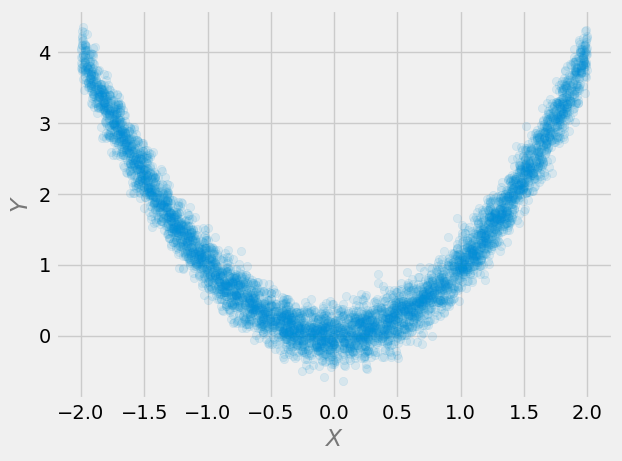

In [27]:
plt.scatter(x, y, alpha=.1)
plt.xlabel('$X$', alpha=.5)
plt.ylabel('$Y$', alpha=.5)
plt.show()

Correlation

In [28]:
stats.spearmanr(x, y)

SignificanceResult(statistic=np.float64(-0.017571125214845006), pvalue=np.float64(0.21414381254206408))

Pearson's `r` and Spearman's `rho` cannot capture *non-monotonic* relationships!

Other tools (?):
    - **maximal information coeficient (MIC)**; and
    - **Hilbert-Schmidt independent criterion (HSIC)**.

Another scenario is your sampling does not cover the entire support of relevant variables:

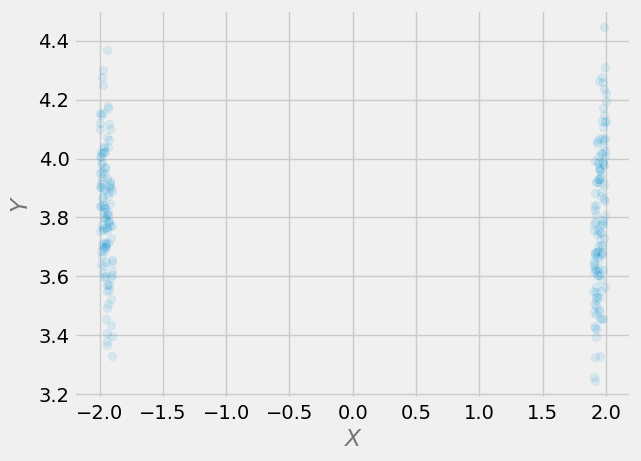

In [29]:
# bad sampling case
# Get initial x
x = np.random.uniform(-2, 2, 5000)

# Filter samples
x = x[np.where((x < -1.9) | (x > 1.9), True, False)]

# Get y
y = x**2 + 0.2*np.random.randn(len(x))

plt.scatter(x, y, alpha=.1)
plt.xlabel('$X$', alpha=.5)
plt.ylabel('$Y$', alpha=.5)
plt.show()

## Counterfactuals (phản thực tế)

> We can think about counterfactuals are minimal modification to a system.

or *hypothetical* or *simulated* interventions.

$P( Y_{X=0} = 1 | X = 1, Y_{X=1} = 1)$

"The probability that you'd feel bad if you hadn't had your coffee, given you had your coffee can you feel bad"

#### Computing counterfactuals - the fundamental problem in causal inference

- **Abduction**: using evidence to calculate balues of exogenous variables;
  - `T := t`, and `Y := TU + (T-1)*(U-1)`;
  - This model allows us to deduct `U`, or `u`: with `T=1`, and `Y=1` it reveals that `u=1`.
- **Modification (or originally called an action)**: replacing the structural equation for the treatment with a counterfactual value;
  - Fix the value of treatment:
  - `T := 0`, and `Y := 0U + (0-1)*(U-1)`;
- **Prediction**: using the modified SCM to compute the new value of the outcome under the counterfactual:
  - Substitue `U=1` computed before:
  - `Y := 0 * 1 + (0-1)*(1-1) = 0`.

This is an example of **Deterministic** counterfactuals, but it real life we would work more versus **Probabilistic** counterfactuals, luckily this framework works well also.


In [30]:
class CounterfactualSCM:
    
    def abduct(self, t, y):
        return (t + y - 1)/(2*t - 1)
    
    def modify(self, t):
        return lambda u: t * u + (t - 1) * (u - 1)
        
    def predict(self, u, t):
        return self.modify(t)(u)

Construction

In [31]:
coffee = CounterfactualSCM()
t = 1
y = 1

Abduction

In [35]:
u = coffee.abduct(t=t, y=y)
u

1.0

Prediction

In [36]:
coffee.predict(u=u, t=0)

0.0